In [1]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *
import math
%matplotlib notebook

<IPython.core.display.Javascript object>


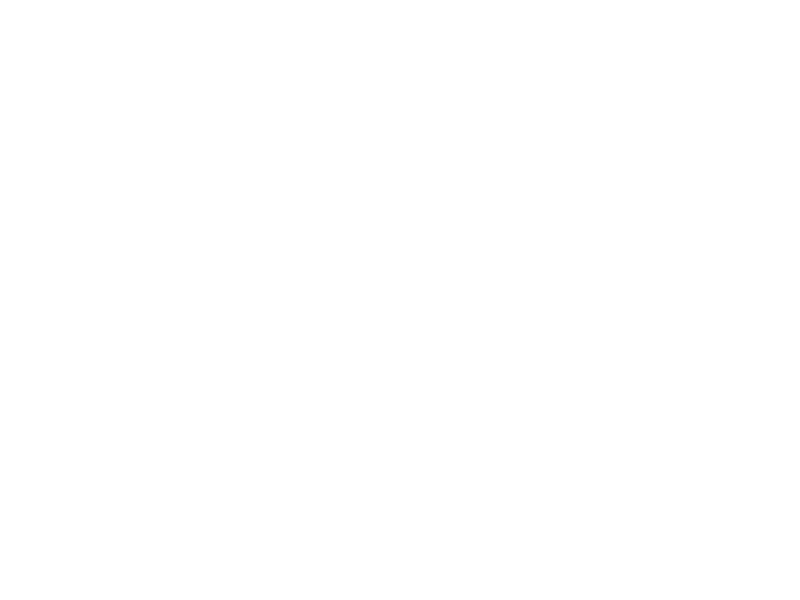

(-9.42477796076938,
 197.92033717615695,
 -32.962622193039266,
 32.962622193039266)

In [2]:
# Eval Param
s = np.linspace(0, 3 * np.pi, 100)

# Evaluated coordinates
ycs = 30 * np.sin(s)
ycs[:50] *= -1
xcs = 20 * s
coords = np.vstack((xcs, ycs)).T

# Plotting the path
plt.figure()
plt.plot(coords[:, 0], coords[:, 1])
plt.axis("equal")

<IPython.core.display.Javascript object>


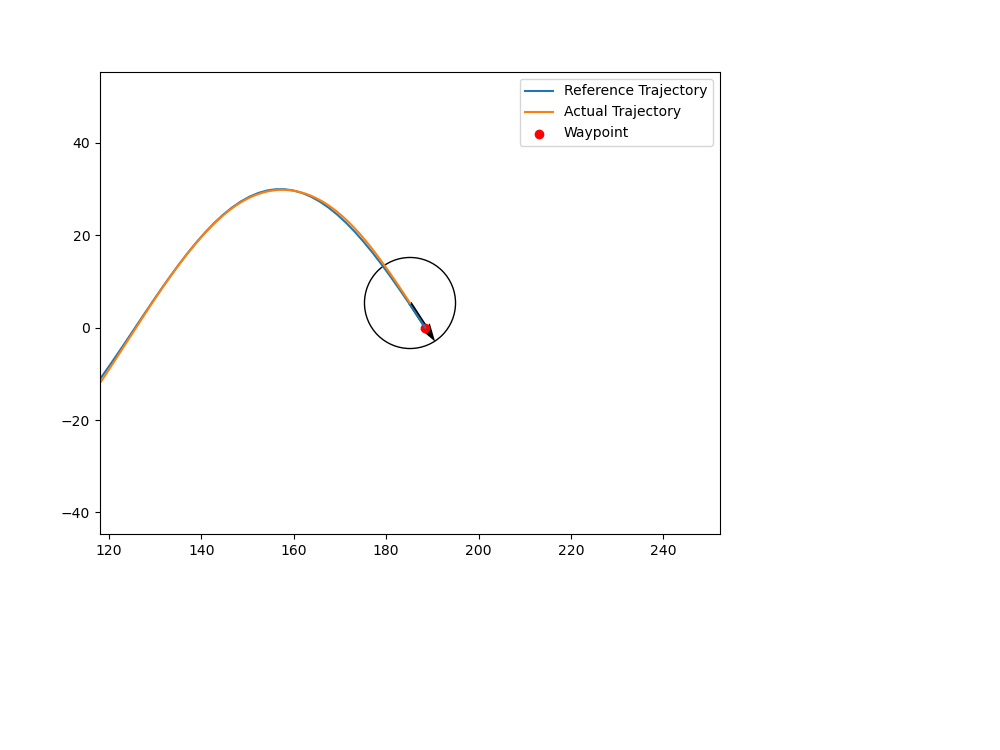

In [ ]:
dt = 0.05
L = 2.8
K = 1.0
R = 10
max_steer = 0.58206731

# Plot range (2 x meter square)
pr = 50

# Motion model
def f(x, u, dt):
    # This function return the change in state wrt time
    # X = [x, y, theta, v, phi]
    # dx/dt = f(x,u) = [dx, dy, d_theta, v]
    return np.array([
        x[0] + x[3]*np.cos(x[2]) * dt, 
        x[1] + x[3]*np.sin(x[2]) * dt, 
        x[2] + x[3]*np.tan(u[1])/L * dt, 
        x[3] + u[0] * dt
    ])

# Init state
x = np.array([coords[0, 0], coords[0, 1], 0.0, 0.1])
xs = [x.copy()]

# Live plotting
%matplotlib notebook

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.set_title("Trajectory")
plt.ion()

fig.show()
fig.canvas.draw()

i_follow = 0
steer = 0
while np.linalg.norm(coords[-1] - x[:2]) > 0.5:
    
    # Finding closest strictly ascending coordinate
    dists = np.linalg.norm(coords - x[:2], axis=1)
    
    # Moving i_follow strictly forward if dist < radius
    dist = np.linalg.norm(coords[i_follow] - x[:2]) # Current distance
    while dist < R * (max_steer - np.abs(steer)) / max_steer and i_follow < (dists.shape[0]-1):
        i_follow += 1
        dist = dists[i_follow]
        
    # Do the pursuit
    # Calc alpha
    h = np.array([np.cos(x[2]), np.sin(x[2])])
    hp = (coords[i_follow] - x[:2])
    hp /= np.linalg.norm(hp) 
    alpha = np.arccos( h@hp )
    sign = np.cross(h, hp)
    sign /= np.abs(sign)
    
    # Calc steer
    steer = np.arctan2(2 * L * np.sin(alpha), K * x[3]) * sign
    steer = max_steer if steer > max_steer else steer
    steer = -max_steer if steer < -max_steer else steer
    
    # Calc v (as a function of steering angle)
    x[3] =  3 + (1 + 0.58206731 - np.abs(steer))**5
    
    # Applying controls
    x = f(x, [0, steer], dt)
    
    xs.append(x.copy())
    
    # Plotting the solution
    ax.clear()
    
    # Plotting path coords
    plt.plot(coords[:, 0], coords[:, 1], label='Reference Trajectory')

    # Robot mark
    circle = plt.Circle((x[0], x[1]), R * (max_steer - np.abs(steer)) / max_steer, color='k', fill=False)
    plt.gca().add_patch(circle)
    # Robot arrow
    plt.quiver(x[0], x[1], np.cos(x[2]), np.sin(x[2]),
               color="k", units='xy', alpha=1, width=0.8, scale=0.1)
    
    plt.scatter(coords[i_follow, 0], coords[i_follow, 1], c='r', label='Waypoint')
    
    xsnp = np.array(xs)
    plt.plot(xsnp[:, 0], xsnp[:, 1], label='Actual Trajectory')

    plt.axis("equal")
    plt.xlim([x[0]-pr, x[0]+pr])
    plt.ylim([x[1]-pr, x[1]+pr])
    plt.legend(loc='best')
    fig.canvas.draw()
    plt.pause(dt)